In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stats302-2023/sample_submission.csv
/kaggle/input/stats302-2023/y_train.npy
/kaggle/input/stats302-2023/X_test.npy
/kaggle/input/stats302-2023/X_train.npy
/kaggle/input/stats302-2023/getting started.ipynb


In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
%matplotlib inline

In [3]:
# load the raw data
X_train = np.load('/kaggle/input/stats302-2023/X_train.npy')
y_train = np.load('/kaggle/input/stats302-2023/y_train.npy')
print('shape of the training data:', X_train.shape)
print('shape of the target data:', y_train.shape)

shape of the training data: (3320, 150, 150)
shape of the target data: (3320,)


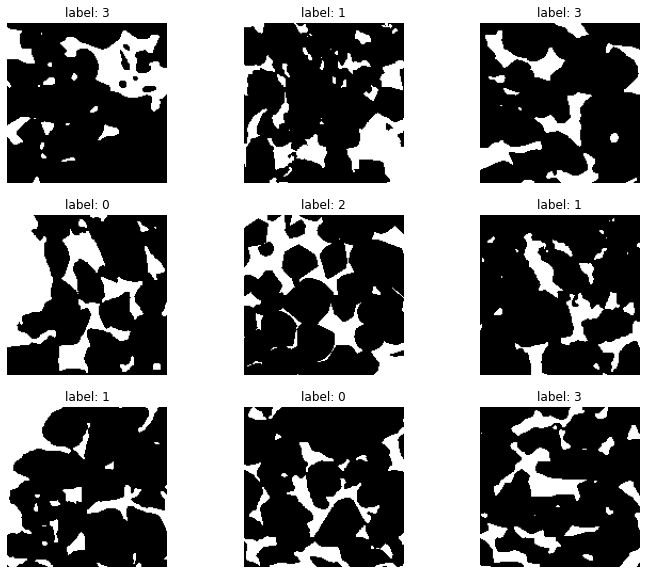

In [4]:
# preview some of the training images
plt.figure(figsize=(12,10))
x, y =3, 3
for i in range(9):  
    plt.subplot(y, x, i+1)
    plt.imshow(X_train[i,:,:],cmap='gray')
    plt.title('label: {}'.format(y_train[i]))
    plt.axis('off')
plt.show()

[[  0 650]
 [  1 640]
 [  2 705]
 [  3 661]]


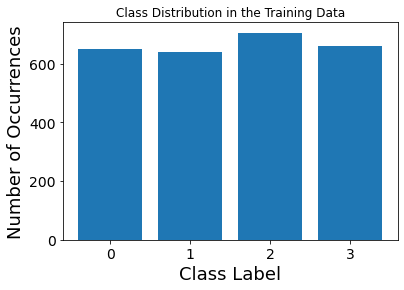

In [5]:
# analyze data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2,random_state=42)


unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

plt.bar(unique, counts)
plt.xlabel('Class Label')
plt.ylabel('Number of Occurrences')
plt.title('Class Distribution in the Training Data')
plt.show()


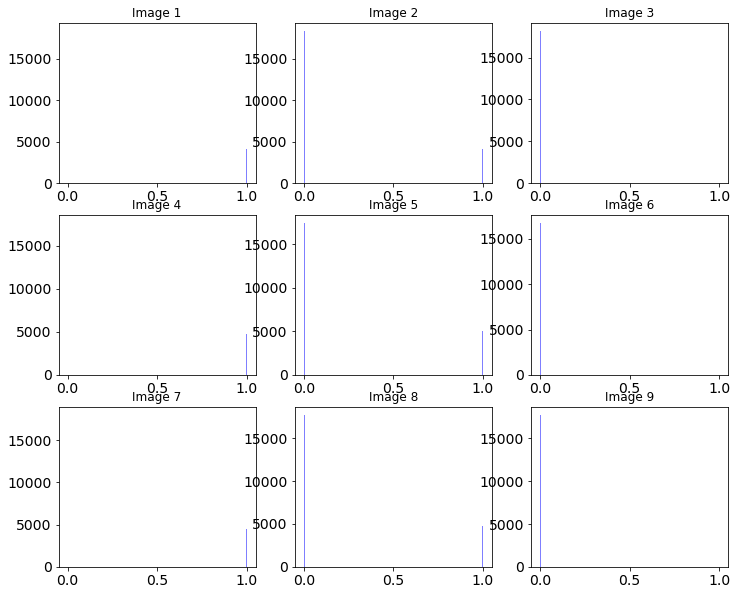

In [6]:

plt.figure(figsize=(12,10))
x, y =3, 3
for i in range(9):  
    plt.subplot(y, x, i+1)
    plt.hist(X_train[i,:,:].ravel(), bins=256, color='blue', alpha=0.5)
    plt.title('Image {}'.format(i+1))
plt.show()


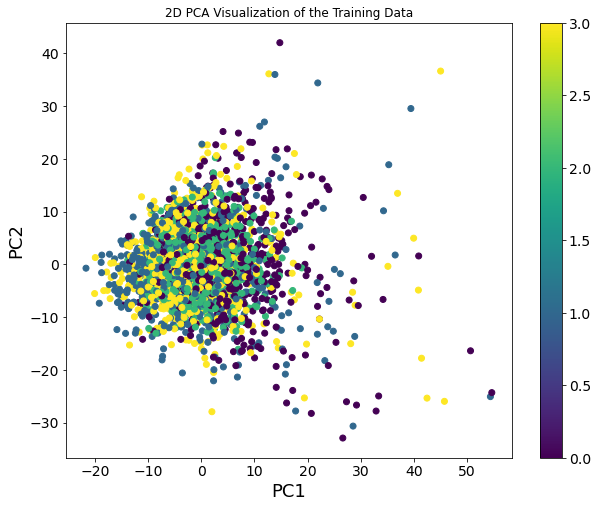

In [7]:

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_reduced = pca.fit_transform(X_train.reshape(X_train.shape[0], -1))

plt.figure(figsize=(10,8))
plt.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], c=y_train, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('2D PCA Visualization of the Training Data')
plt.colorbar()
plt.show()


In [8]:
from keras.utils.np_utils import to_categorical
X_train = X_train.reshape(X_train.shape[0], 150, 150, 1)
X_test = X_test.reshape(X_test.shape[0], 150, 150, 1)
y_train = to_categorical(y_train,4)
y_test= to_categorical(y_test,4)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(horizontal_flip=True, 
                                 vertical_flip=True,
                                 shear_range=0.1,
                                 zoom_range=0.1)
test_datagen=ImageDataGenerator()
train_generator=train_datagen.flow(X_train,y_train,batch_size=30)
validation_generator=test_datagen.flow(X_test,y_test,batch_size=30)

In [10]:
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import GlobalAveragePooling2D

# Define the model architecture
model = Sequential()
model.add(Conv2D(64,input_shape=(150,150,1),kernel_size=(5,5),activation='relu',padding='same'))
model.add(Dropout(0.1))

model.add(Conv2D(32,kernel_size=(5,5),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))


model.add(Conv2D(32,kernel_size=(5,5),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.3))

model.add(Conv2D(32,kernel_size=(5,5),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.6))

model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(4,activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer= 'Adam')

history = model.fit(
      train_generator,
      steps_per_epoch= 50,  
      epochs= 200, #change it to 200, I use 50 here to get a faster result
      validation_data=validation_generator,
      verbose=1)

2023-02-12 13:42:05.682465: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-12 13:42:05.769121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-12 13:42:05.769931: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-12 13:42:05.771009: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      1664      
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      51232     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0

2023-02-12 13:42:08.457354: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-12 13:42:09.840666: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


50/50 [==============================] - 11s 75ms/step - loss: 1.3889 - accuracy: 0.2530 - val_loss: 1.3863 - val_accuracy: 0.2395
Epoch 2/200
50/50 [==============================] - 3s 64ms/step - loss: 1.3850 - accuracy: 0.2631 - val_loss: 1.3857 - val_accuracy: 0.2425
Epoch 3/200
50/50 [==============================] - 3s 64ms/step - loss: 1.3845 - accuracy: 0.2567 - val_loss: 1.3848 - val_accuracy: 0.2395
Epoch 4/200
50/50 [==============================] - 3s 69ms/step - loss: 1.3824 - accuracy: 0.2667 - val_loss: 1.3802 - val_accuracy: 0.4413
Epoch 5/200
50/50 [==============================] - 3s 64ms/step - loss: 1.3586 - accuracy: 0.3385 - val_loss: 1.3129 - val_accuracy: 0.4623
Epoch 6/200
50/50 [==============================] - 3s 69ms/step - loss: 1.2894 - accuracy: 0.3913 - val_loss: 1.1985 - val_accuracy: 0.5105
Epoch 7/200
50/50 [==============================] - 3s 62ms/step - loss: 1.2125 - accuracy: 0.4527 - val_loss: 1.2327 - val_accuracy: 0.4096
Epoch 8/200
50/50

In [11]:
# load the test data
X_test = np.load('/kaggle/input/stats302-2023/X_test.npy')
print('shape of the test data:', X_test.shape)

shape of the test data: (830, 150, 150)


In [12]:
# Make predictions for the test data
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
np.save('y_pred.npy', y_pred_classes)

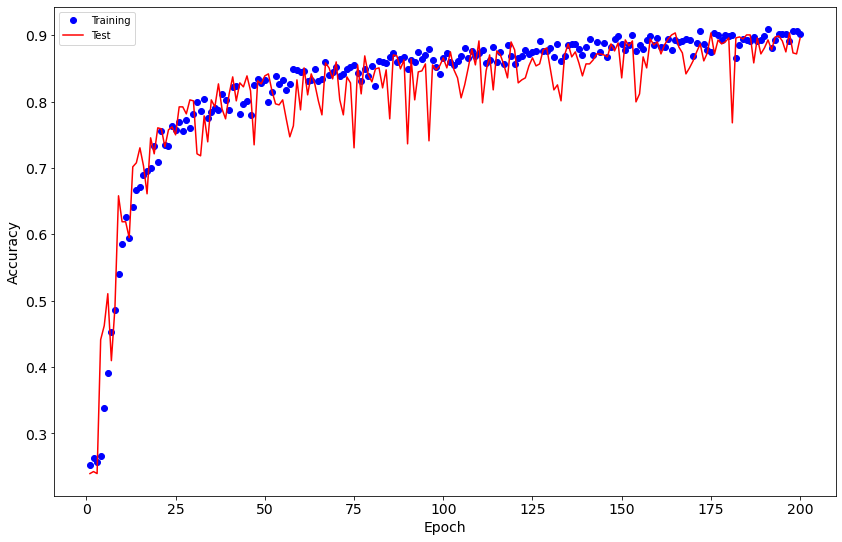

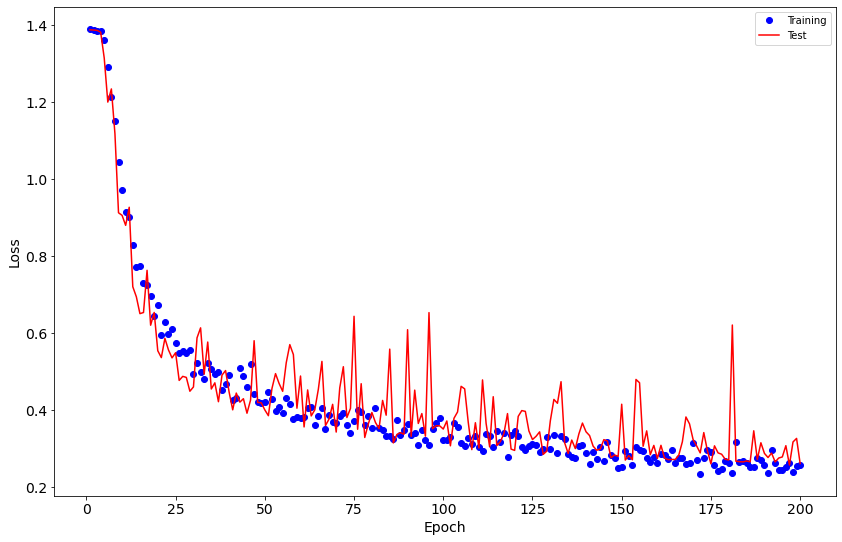

In [13]:
# show the learning process
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(accuracy)+1)

plt.figure(figsize=(14,9))
plt.plot(epochs, accuracy, 'bo', label='Training')
plt.plot(epochs, val_accuracy, 'r', label='Test')
plt.xlabel('Epoch', size=14)
plt.ylabel('Accuracy', size=14)
plt.legend()
plt.show()

plt.figure(figsize=(14,9))
plt.plot(epochs, loss, 'bo', label='Training')
plt.plot(epochs, val_loss, 'r', label='Test')
plt.xlabel('Epoch', size=14)
plt.ylabel('Loss', size=14)
plt.legend()
#plt.savefig('loss.png')
plt.show()

In [14]:
import pandas as pd

# Create a submission dataframe
submission = pd.DataFrame({'Id': range(0, len(y_pred_classes)), 'Category': y_pred_classes})

# Save the submission dataframe to a CSV file
submission.to_csv('submission.csv', index=False)
